In [1]:
# Import libraries
import os
import numpy as np
import torch
import pandas as pd

In [2]:
# Load data
file = "LD2011_2014_clean.txt"
isExist = os.path.exists(file)
if not isExist:
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
    !unzip LD2011_2014.txt.zip
    # change commas to dots
    !sed 's/,/./g' LD2011_2014.txt > LD2011_2014_clean.txt
else: 
    print(f"Files are ready")

Files are ready


In [3]:
"""Preprocess data"""
data = pd.read_csv('LD2011_2014_clean.txt', delimiter = ';')
#remove data before 2012
data = data.iloc[8760*4:]
print('Data loaded..')
data_2 = data.copy()
#pick the first 20 houses
data_2 = data_2.iloc[:,:]
# Aggregate
data_2['time'] =pd.to_datetime(data_2['Unnamed: 0']).dt.ceil('1h') 
data_2 = data_2.drop(['Unnamed: 0'], axis = 1)
agg_dict = {}
for col in data_2.columns[:-1]:
    agg_dict[col] ='mean'
aggregated_data = data_2.groupby(['time']).agg(agg_dict)
print('Data aggregated by hour')
aggregated_data.shape

Data loaded..
Data aggregated by hour


(26304, 370)

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
Std_normalization = 1
if Std_normalization:
    scaler = StandardScaler()
    temp = scaler.fit_transform(aggregated_data)
    norm_means = scaler.mean_
    norm_std = scaler.scale_
else:
    scaler = MinMaxScaler()
    temp = scaler.fit_transform(aggregated_data)
global data_4
normalized_data = pd.DataFrame(temp, index=aggregated_data.index, columns = aggregated_data.columns)

In [5]:
normalized_data.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,-0.193637,-0.767048,5.979015,0.750556,1.297119,2.562526,0.380006,0.420689,0.936652,1.237010,...,-0.925467,-0.660711,-0.611351,-0.924599,-1.182866,0.055241,-0.298429,-0.970811,-0.867907,-1.312616
2012-01-01 02:00:00,-0.088516,-0.711666,5.979015,0.723940,1.174705,2.419487,0.131533,0.362440,0.666522,1.016322,...,-0.968145,-0.718147,-0.862776,-0.926923,-1.177477,-0.195217,-0.111780,-0.964607,-0.923605,-1.312616
2012-01-01 03:00:00,-0.193637,-0.739357,5.979015,0.710631,0.964851,1.573172,0.090121,-0.263732,0.500288,0.616982,...,-1.023433,-0.710625,-0.879452,-0.931572,-1.177477,-0.289139,-0.478750,-1.119708,-1.044284,-1.312616
2012-01-01 04:00:00,-0.088516,-0.877811,5.979015,-0.194342,0.037999,0.059340,-0.179057,-0.948152,-0.559453,-0.391876,...,-1.228097,-0.732505,-0.896128,-0.957141,-1.139759,-0.289139,-1.696712,-1.175544,-1.102634,-1.312616
2012-01-01 05:00:00,-0.141076,-0.905502,5.979015,-0.726679,-0.259294,-0.524736,-0.365412,-1.297643,-0.351661,-0.539002,...,-1.179598,-0.753702,-0.901901,-0.961790,-1.182866,-0.383061,-1.707784,-1.169340,-1.072133,-1.312616


In [6]:
global n_clients; global data_train; global data_test
def set_train_test(n_clients=20):
    data_train = normalized_data.iloc[:25968,:n_clients] #25600; 25968; 26082
    data_test = normalized_data.iloc[25968:,:n_clients]
    return data_train, data_test

In [7]:
data_train, data_test = set_train_test(n_clients=20)
data_train.shape, data_test.shape

((25968, 20), (336, 20))

In [8]:
"""

Create missing values based on normal distribution random choice

Input: 
 - pd_data: 2d pandas data frame
 - missing_percentage: missing percentage <= 100

Output:
 - return_data: 2d pandas with missed values

"""
def create_missing_data(pd_data, missing_percentage = 20):
    if missing_percentage == 0: return pd_data
    assert missing_percentage <= 100, "missing percentage should be less than or equal 100%"
    np.random.seed(1993)
    # Convert data frame to array
    np_data = pd_data.to_numpy()
    # Convert original data to 1d array - Because existing package only supports to randomly choose indices from 1d array
    np_data_1d = np_data.flatten()
    # Randomly choose missing index
    total_elem = np_data_1d.shape[0]
    number_of_missing_elem = int(missing_percentage*1.0*total_elem/100)
    missing_index = np.random.choice(np.arange(total_elem), number_of_missing_elem, replace=False) # with replace = False, an index only is chosen 1 time
    # Replace missing_index with 0
    np_data_1d[missing_index] = 0
    # Convert 1d array to 2d array
    np_data_2d = np_data_1d.reshape(pd_data.shape[0], pd_data.shape[1])
    # Convert 2d array to dataframe
    cols_name = pd_data.columns
    return_data = pd.DataFrame(np_data_2d, columns = cols_name)
    return_data.index = pd_data.index
    return return_data

missing_df = create_missing_data(normalized_data, missing_percentage=20)
missing_df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,-0.193637,0.000000,0.000000,0.750556,1.297119,2.562526,0.380006,0.420689,0.936652,1.237010,...,0.000000,-0.660711,-0.611351,-0.924599,-1.182866,0.000000,-0.298429,0.000000,-0.867907,-1.312616
2012-01-01 02:00:00,-0.088516,-0.711666,5.979015,0.723940,0.000000,0.000000,0.131533,0.362440,0.000000,1.016322,...,0.000000,-0.718147,-0.862776,-0.926923,-1.177477,-0.195217,-0.111780,-0.964607,-0.923605,-1.312616
2012-01-01 03:00:00,-0.193637,-0.739357,0.000000,0.710631,0.000000,0.000000,0.090121,-0.263732,0.500288,0.616982,...,-1.023433,-0.710625,-0.879452,-0.931572,-1.177477,0.000000,0.000000,-1.119708,-1.044284,0.000000
2012-01-01 04:00:00,0.000000,-0.877811,5.979015,-0.194342,0.037999,0.059340,-0.179057,-0.948152,0.000000,-0.391876,...,-1.228097,-0.732505,-0.896128,-0.957141,0.000000,-0.289139,0.000000,-1.175544,0.000000,-1.312616
2012-01-01 05:00:00,0.000000,-0.905502,5.979015,-0.726679,-0.259294,0.000000,-0.365412,-1.297643,-0.351661,-0.539002,...,-1.179598,-0.753702,-0.901901,0.000000,-1.182866,0.000000,-1.707784,-1.169340,0.000000,-1.312616


In [9]:
# Define parameters
n_users = 20 
window  = 40
missing_percentage = 40
prediction_steps = 24 # 1 day prediction

In [10]:
# Create missing data for training
data_train_missing_vals = create_missing_data(data_train, missing_percentage=missing_percentage)
data_train_missing_vals.shape

(25968, 20)

In [11]:
# Convert data to type of array
data_train_missing_vals_np = data_train_missing_vals.to_numpy()
data_test_np = data_test.to_numpy()
# Check shape
data_train_missing_vals_np.shape, data_test_np.shape

((25968, 20), (336, 20))

In [12]:
# Change shape
data_train_missing_vals_np = data_train_missing_vals_np.T 
data_test_np = data_test_np.T 
data_train_missing_vals_np.shape, data_test_np.shape

((20, 25968), (20, 336))

In [13]:
# Create ts data for Dataset
def create_np_train_data(train_data, window=window):
    length_ts_data = train_data.shape[0]
    x_test = []
    y_test = []

    for i in range(length_ts_data - window):
        x_test.append(train_data[i:i+window])
        y_test.append(train_data[i+window])
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    return x_test, y_test
# Test function creating data by using window
X = data_train_missing_vals_np[0]
x, y = create_np_train_data(data_train_missing_vals_np[0], window=window)
x.shape, y.shape

((25928, 40), (25928,))

In [14]:
data_x_missing_vals_window = []
data_y_missing_vals_window = []

for user_id in range(n_users):
    x_missing_data, y_missing_data = create_np_train_data(data_train_missing_vals_np[user_id], window=window)
    data_x_missing_vals_window.append(x_missing_data)
    data_y_missing_vals_window.append(y_missing_data)
    # break 
data_x_missing_vals_window = np.array(data_x_missing_vals_window)
data_y_missing_vals_window = np.array(data_y_missing_vals_window)
data_x_missing_vals_window.shape, data_y_missing_vals_window.shape

((20, 25928, 40), (20, 25928))

In [15]:
for i in range(n_users):
    if i == 0:
        data_x = data_x_missing_vals_window[0]
        data_y = data_y_missing_vals_window[0]
    else: 
        data_x = np.concatenate((data_x, data_x_missing_vals_window[i]))
        data_y = np.concatenate((data_y, data_y_missing_vals_window[i]))
data_x.shape, data_y.shape

((518560, 40), (518560,))

In [16]:
from torch.utils.data import Dataset

# Create dataset
class timeseries(Dataset):
  def __init__(self, x, y):
    self.x = torch.Tensor(x)
    self.y = torch.Tensor(y)
    self.len = x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx] 
  
  def __len__(self):
    return self.len

dataset = timeseries(data_x, data_y)

# Create dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, shuffle=True, batch_size=64)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [18]:
from torch import nn

class LSTM_nn(nn.Module):
    def __init__(self):
        super(LSTM_nn,self).__init__()
        self.lstm = nn.LSTM(input_size=1,hidden_size=5,num_layers=3,batch_first=True)
        self.fc1 = nn.Linear(in_features=5,out_features=1)

    def forward(self,x):
        output, _status = self.lstm(x)
        output = output[:,-1,:]
        output = self.fc1(torch.relu(output))
        return output

model = LSTM_nn()
model = model.to(device)

In [19]:
# optimizer , loss
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
epochs = 20

In [20]:
#training loop
for i in range(epochs):
    for data in train_loader:
        input, label = data
        input = input.view(-1,window,1)
        input, label = input.to(device), label.to(device)
        # print(input.shape)
        y_pred = model(input).reshape(-1)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
    if i%10 == 0:
        print(i,"th iteration : ",loss)

0 th iteration :  tensor(0.5361, device='cuda:0', grad_fn=<MseLossBackward0>)
10 th iteration :  tensor(0.9982, device='cuda:0', grad_fn=<MseLossBackward0>)


In [21]:
"""Prepare data to test the model"""

# Get the last window training data
data_train_missing_vals_np
# Get the last window of train data
last_window = data_train_missing_vals_np[:, -window:]

# Get actual data for prediction steps
actual_steps = data_test_np[:, -prediction_steps:]

# Check shape
last_window.shape, actual_steps.shape

((20, 40), (20, 24))

In [22]:
def create_test_np_data(user_test_data, prediction_steps=24):
    x_test = []
    y_test = []

    for i in range(prediction_steps):
        x_test.append(user_test_data[i:i+window])
        y_test.append(user_test_data[i+window])
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    return x_test, y_test

In [23]:
model

LSTM_nn(
  (lstm): LSTM(1, 5, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=5, out_features=1, bias=True)
)

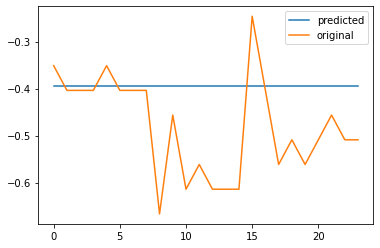

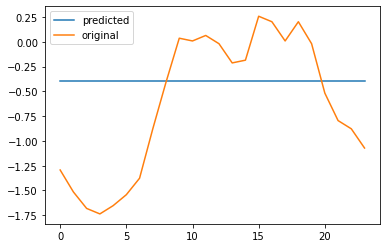

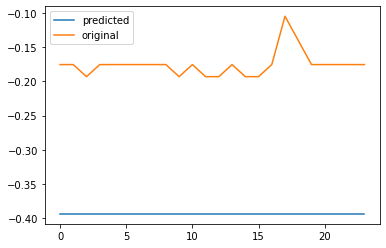

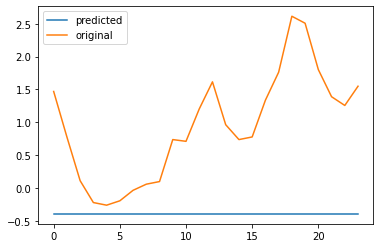

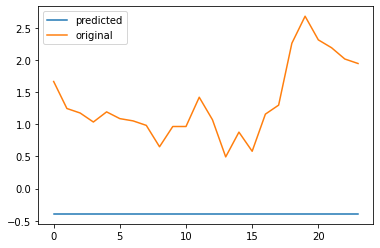

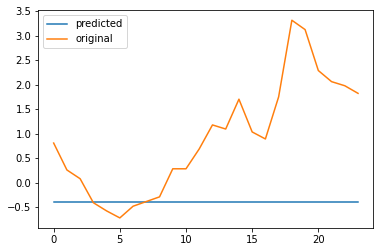

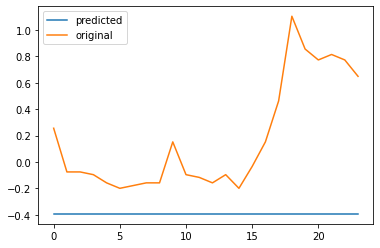

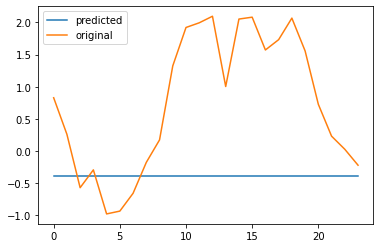

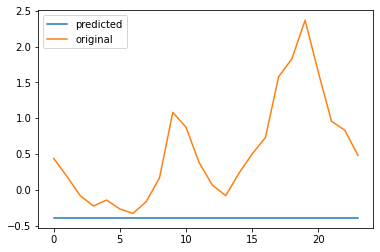

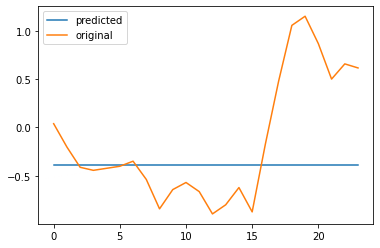

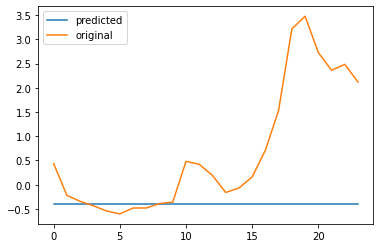

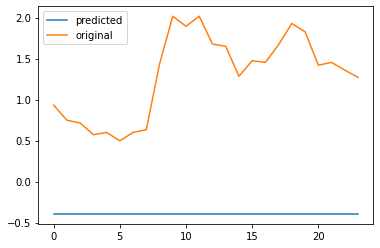

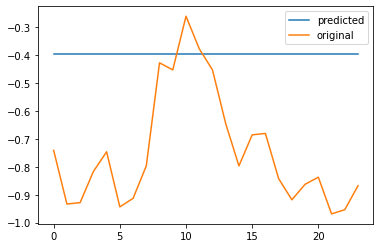

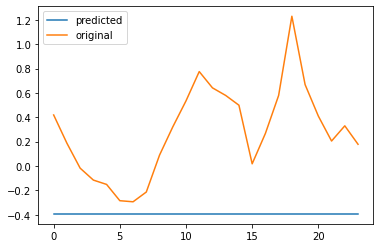

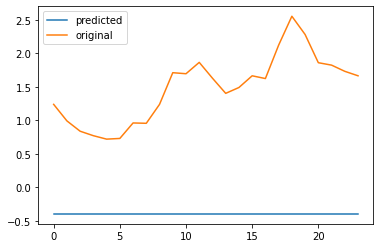

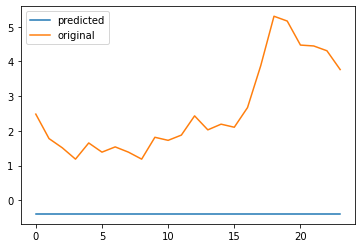

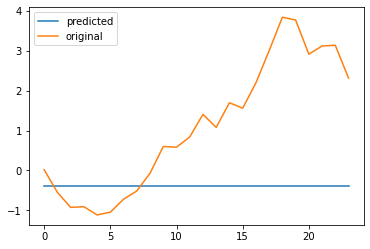

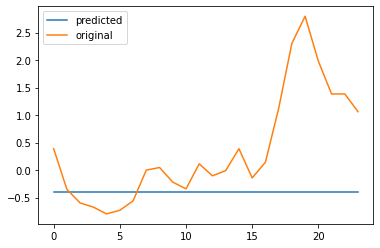

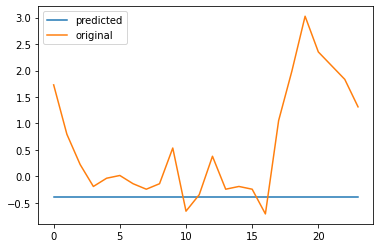

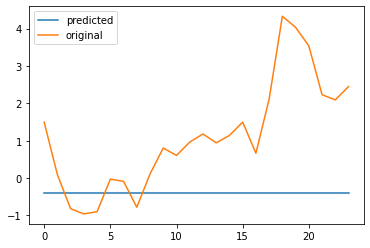

RMSE LSTM: 1.549548864364624


In [24]:
import matplotlib.pyplot as plt
diff_list = []
y_pred = []
y_true = []
for user_id in range(n_users):
    user_last_window = last_window[user_id]
    user_actual_steps = actual_steps[user_id]
    user_test_data = np.concatenate((user_last_window, user_actual_steps), axis=None)
    # print(f"{user_last_window.shape}, {user_actual_steps.shape}, {user_test_data.shape}")

    """Create input data for data model"""
    # Create np data
    x_test, y_test = create_test_np_data(user_test_data=user_test_data, prediction_steps=prediction_steps)
    # Cretate dataset
    test_set = timeseries(x_test, y_test)
    # Prediction
    input = test_set[:][0].view(-1,window,1)
    actual = test_set[:][1].view(-1)
    input = input.to(device)
    test_pred = model(input).view(-1)
    predictions_24 = test_pred.cpu().detach().numpy()
    actual = actual.numpy()
    diff = predictions_24 - actual
    diff_list.append(diff)
    plt.plot(predictions_24, label='predicted')
    plt.plot(actual, label='original')
    plt.legend()
    plt.plot()
    plt.show()
    # break
    y_pred.append(predictions_24)
    y_true.append(actual)
diff_np = np.array(diff_list)
rmse = np.sqrt(np.mean(np.square(diff_np)))
print(f"RMSE LSTM: {rmse}")

In [25]:
model_path = os.path.join("models", "centralized_lstm")
torch.save(model, os.path.join(model_path, "centralized_lstm_num_user_20_missing_20" + ".pt"))

In [26]:
y_pred_np = np.array(y_pred)
y_true_np = np.array(y_true)

y_pred_np.shape, y_true_np.shape

((20, 24), (20, 24))

In [27]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
def evaluate_Testset(y_true, y_pred):
    def mape(y_true, y_pred): 
      return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    MSE = mse(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    MAE = mae(y_true, y_pred)
    MAPE = mape(y_true, y_pred)
    return MSE, RMSE, MAE, MAPE

def accuracy_Testset(y_true, y_pred):
  diff_pred = list()
  diff_true = list()
  accuracy = 0.
  for i in range(len(y_true)-1):
      diff_pred.append(y_pred[i+1]-y_pred[i])
      diff_true.append(y_true[i+1]-y_true[i])
  count = sum(diff_pred[i] * diff_true[i] > 0 for i in range(len(diff_pred)))
  accuracy = count/len(diff_pred) * 100
  return accuracy

In [28]:
MSE, RMSE, MAE, MAPE = evaluate_Testset(y_true_np, y_pred_np)
acc = accuracy_Testset(y_true_np, y_pred_np)
print(f"MSE: {MSE}, RMSE: {RMSE}, MAE: {MAE}, MAPE: {MAPE}")
# print(f"acc: {acc}")

MSE: 2.4011013507843018, RMSE: 1.5495487451553345, MAE: 1.1336345672607422, MAPE: 292.545485496521
